# 기계학습 (60점)

### 전국 병의원 데이터
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m1.csv    
출처 : https://www.data.go.kr/data/15083033/fileData.do    
        
전국의 병의원 (치과의원,의원,한의원)의 정보이다.           
        

In [483]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_location = 'C:\Windows\Fonts\malgun.ttf' # 폰트 파일 이름, 디렉토리 주의
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family=font_name)

# 현재 글꼴 확인
print(plt.rcParams['font.family'])

['Malgun Gothic']


In [484]:
import pandas as pd 
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m1.csv')
df.sample(5)

,사업장명,업태구분명,진료과목내용명,도로명전체주소,인허가일자,상세영업상태명,폐업일자
5130,강촌한의원,한의원,"한방내과, 한방부인과, 한방소아과, 한방안·이비인후·피부과, 한방신경정신과, 한방재...","대구광역시 동구 화랑로80길 8, 147동 203호 (방촌동, 우방강촌마을상가)",2002-06-17,영업중,NaN
943,정다운의원,의원,"내과, 외과, 정형외과, 심장혈관흉부외과, 성형외과, 마취통증의학과, 소아청소년과,...","충청북도 음성군 감곡면 장감로 137, 2층 (소망빌딩)",2009-03-11,영업중,NaN
17939,한치과의원,치과의원,치과,전북특별자치도 남원시 춘향로 21 (도통동),2004-04-19,영업중,NaN
9087,안양톤즈의원,의원,피부과,"경기도 안양시 동안구 평촌대로223번길 31, 동안상가 5층 501,502호 (호계동)",2019-06-04,영업중,NaN
44706,우리진단방사선과의원,의원,영상의학과,"서울특별시 강남구 역삼로38길 6, 1층 (역삼동)",2003-12-01,영업중,NaN


### 기계학습1
시각화를 포함한 데이터 EDA

In [485]:
def resume(df):
    print(df.shape)
    tmp = pd.DataFrame()
    tmp['타입'] = df.dtypes
    tmp['결측치'] = df.isna().sum()
    tmp['고유값'] = df.nunique()
    tmp['샘플고유'] = pd.Series([df.iloc[:,i].unique()[:3] for i in range(df.shape[1])],index=df.columns)
    tmp['첫번째'] = df.iloc[0,:]
    # tmp['두번째'] = df.iloc[1,:]    
    return tmp
resume(df)

(94102, 7)


,타입,결측치,고유값,샘플고유,첫번째
사업장명,object,0,57616,"[효치과의원, 일곡부부치과의원, 사랑이가득한치과의원]",효치과의원
업태구분명,object,0,3,"[치과의원, 한의원, 의원]",치과의원
진료과목내용명,object,0,7954,"[치과, 한방내과, 한방부인과, 한방소아과, 한방안·이비인후·피부과, 한방신경정신과...",치과
도로명전체주소,object,0,85917,"[광주광역시 북구 동문대로 24, 3층 (풍향동), 광주광역시 북구 설죽로 518,...","광주광역시 북구 동문대로 24, 3층 (풍향동)"
인허가일자,object,0,12138,"[1999-06-12, 1999-07-07, 1999-07-13]",1999-06-12
상세영업상태명,object,0,2,"[영업중, 폐업]",영업중
폐업일자,object,66056,6659,"[nan, 2019-02-16, 2015-10-11]",NaN


- 94102개의 샘플, 7개의 특성 가진 데이터
- 3종의 업태구분 : 치과의원, 한의원, 의원
- 병원 별 단과진단, 또는 다수의 과목을 진단하는 경우도 있음
- 인허가일자에 따라 운영연차 계산가능

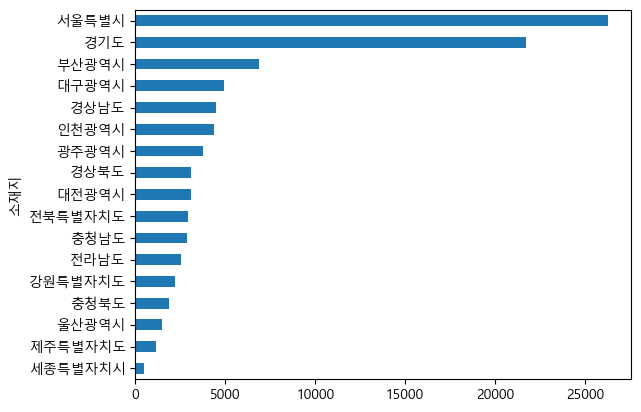

In [466]:
df['소재지'] = df['도로명전체주소'].str.split(' ').str[0]
df['소재지'].value_counts().sort_values(ascending = True).plot(kind='barh');

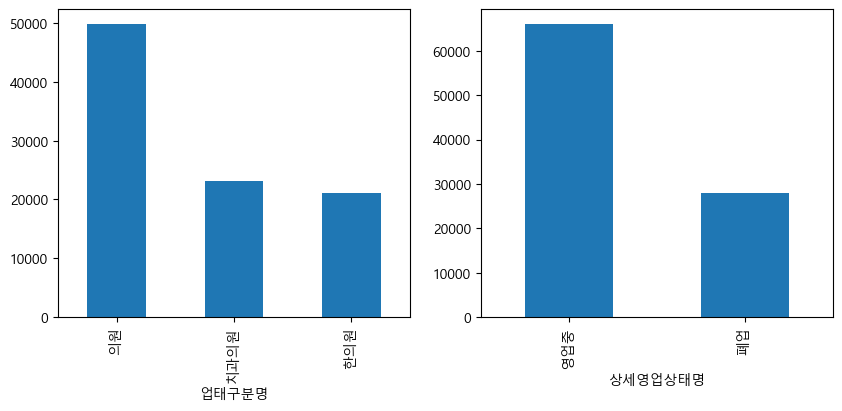

In [486]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax1 = df['업태구분명'].value_counts().plot(kind = 'bar', ax = ax[0] )
ax2 = df['상세영업상태명'].value_counts().plot(kind = 'bar', ax = ax[1])
# ax1.set_title('업태구분명')
# ax2.set_title('상세영업상태명')

### 기계학습2
진료과목내용명의 연관분석을 진행하려한다.     
업태를 의원,한의원,치과의원 각각 나누어 데이터 전처리 및 트랜잭션 변환을 진행하라

업태를 각각 나누어서 df생성

In [537]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
dfs = {업태:df[df['업태구분명'] == 업태] for 업태 in df['업태구분명'].unique()}
def transform(tmp):
    # 연관분석을 위해 이중리스트를 만든다
    lis = tmp['진료과목내용명'].str.split(',')
    te =TransactionEncoder()
    te_arr = te.fit_transform(lis)
    my_set = set([i for item in [*tmp['진료과목내용명'].str.split(',').values] for i in item ])
    my_list = [item for item in my_set]
    return pd.DataFrame(te_arr, columns= my_list)
dfs_t = {}
for df_ in dfs:
    tmp = transform(dfs[df_])
    dfs_t[df_]=tmp

,support,itemsets
0,0.394296,(치과보철과)
1,0.420182,( 치주과)
2,0.311106,( 소아치과)
3,0.391054,(내과)
4,0.371435,( 구강내과)
...,...,...
240,0.334356,"( 내과, 치과, 한방부인과, 예방의학과, 치주과, 내과)"
241,0.313613,"( 내과, 구강내과, 치과, 한방부인과, 예방의학과, 치주과)"
242,0.300994,"( 구강내과, 치과보철과, 치과, 한방부인과, 예방의학과, 치주과, 내과)"
243,0.324417,"( 내과, 치과보철과, 치과, 한방부인과, 예방의학과, 치주과, 내과)"


### 기계학습3
업태별로 연관 규칙 생성 및 평가 지표 계산을 진행하라    

In [541]:
for df_ in dfs_t:
    print(f'==={df_} 연관도 분석===')
    frqset =apriori(dfs_t[df_], min_support=0.3, use_colnames=True)
    # 향상도 1 이상 빈번항목 생성
    rule = association_rules(frqset, metric = 'lift', min_threshold=1)
    # 각각 향상도 높은 top5선정
    display(rule[:5])

===치과의원 연관도 분석===


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 치주과),(치과보철과),0.420182,0.394296,0.377398,0.898180,2.277935,0.211723,5.948751,0.967554
1,(치과보철과),( 치주과),0.394296,0.420182,0.377398,0.957146,2.277935,0.211723,13.530087,0.926204
2,( 소아치과),(치과보철과),0.311106,0.394296,0.301642,0.969579,2.459016,0.178974,19.910804,0.861284
3,(치과보철과),( 소아치과),0.394296,0.311106,0.301642,0.765015,2.459016,0.178974,2.931654,0.979576
4,(내과),(치과보철과),0.391054,0.394296,0.361495,0.924412,2.344463,0.207304,8.013186,0.941731


===한의원 연관도 분석===


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(한방내과),(한방응급과),0.899256,0.737336,0.729517,0.811245,1.100238,0.066463,1.391562,0.904332
1,(한방응급과),(한방내과),0.737336,0.899256,0.729517,0.989396,1.100238,0.066463,9.500462,0.346854
2,(치과),(한방응급과),0.909539,0.737336,0.731839,0.804626,1.091262,0.061203,1.344420,0.924481
3,(한방응급과),(치과),0.737336,0.909539,0.731839,0.992545,1.091262,0.061203,12.134261,0.318390
4,( 소아청소년과),(한방응급과),0.905558,0.737336,0.731934,0.808268,1.096200,0.064233,1.369954,0.929231


===의원 연관도 분석===


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(진단검사의학과),(내과),0.565354,0.378668,0.368740,0.652228,1.722427,0.154658,1.786607,0.964979
1,(내과),(진단검사의학과),0.378668,0.565354,0.368740,0.973782,1.722427,0.154658,16.578002,0.675040
2,(진단검사의학과),( 응급의학과),0.565354,0.407008,0.323171,0.571626,1.404460,0.093068,1.384287,0.662569
3,( 응급의학과),(진단검사의학과),0.407008,0.565354,0.323171,0.794018,1.404460,0.093068,2.110111,0.485643


### 기계학습4
연관 규칙 해석 및 업태별 개업시 전략을 제안하라    

```
===치과의원===

치주과와 치과보철과 간의 연관성이 매우 높습니다. 이는 치주 질환 치료와 보철 치료가 밀접하게 연관되어 있음을 의미합니다. 따라서 치과의원 개업 시 치주과와 치과보철과를 함께 운영하는 것이 바람직합니다.
소아치과와 치과보철과 간의 연관성도 높은 편입니다. 이는 소아 환자의 경우 보철 치료 수요가 높음을 시사합니다. 따라서 소아치과와 치과보철과를 함께 운영하면 시너지 효과를 기대할 수 있습니다.
내과와 치과보철과 간의 연관성도 있는 것으로 나타났습니다. 이는 전신 질환과 구강 건강의 연관성을 반영하는 것으로 보입니다. 따라서 내과와 협력하여 환자 관리를 하는 것이 좋습니다.


===한의원===

한방내과와 한방응급과 간의 연관성이 매우 높습니다. 이는 한방 치료에서 내과 질환과 응급 상황이 밀접하게 연관되어 있음을 의미합니다. 따라서 한의원 개업 시 한방내과와 한방응급과를 함께 운영하는 것이 바람직합니다.
치과와 한방응급과 간의 연관성도 높은 편입니다. 이는 치과 질환과 한방 응급 치료의 연관성을 시사합니다. 따라서 치과와 협력하여 환자를 공유하는 전략을 고려해볼 수 있습니다.
소아청소년과와 한방응급과 간의 연관성도 있는 것으로 나타났습니다. 이는 소아청소년 환자의 한방 응급 치료 수요가 있음을 의미합니다. 따라서 소아청소년과와 협력하여 환자 유치 전략을 수립할 필요가 있습니다.


===의원===

진단검사의학과와 내과 간의 연관성이 매우 높습니다. 이는 내과 진료에서 진단검사의 중요성을 반영하는 것으로 보입니다. 따라서 의원 개업 시 진단검사의학과와 내과를 함께 운영하는 것이 바람직합니다.
진단검사의학과와 응급의학과 간의 연관성도 높은 편입니다. 이는 응급 상황에서 진단검사의 중요성을 시사합니다. 따라서 응급의학과와 협력하여 환자 관리를 하는 것이 좋습니다.

전반적으로 연관성이 높은 진료과목들을 함께 운영하거나 협력하는 전략이 필요해 보입니다. 또한, 환자 유치를 위해 연관성이 높은 타 의료기관과 협력하는 것도 고려해볼 수 있습니다.
```

### 서울의 미세먼지 데이터
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m2.csv    
출처 : https://www.data.go.kr/data/15089266/fileData.do
        
2020년~ 2022년도의 서울 각 지역구의 시간별    
미세먼지(pm10)와 초미세먼지(pm25)데이터이다.         
하루동안의 미세먼지(pm10)와 지역구,시간 정보를 바탕으로 다음날 00:00시의 해당 지역구의 초미세먼지(pm25)를      
예측하는 회귀 모델을 만들려고 한다.   

In [296]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m2.csv')

In [297]:
resume(df)

(657598, 6)


,타입,결측치,고유값,샘플고유,첫번째
일시,object,0,26304,"[2022-12-31 23:00:00, 2022-12-31 22:00:00, 202...",2022-12-31 23:00:00
구분,object,0,25,"[강남구, 강동구, 강북구]",강남구
pm10,float64,14508,765,"[57.0, 68.0, 59.0]",57.0
pm25,float64,11558,209,"[44.0, 55.0, 42.0]",44.0
date,object,0,1096,"[2022-12-31, 2022-12-30, 2022-12-29]",2022-12-31
hour,int64,0,24,"[23, 22, 21]",23


- 657598개의 샘플, 6개의 특성을 지닌 데이터로
- 날짜 및 시간에 따른 미세먼지 및 초미세먼지의 변화를 나타냄
    - 월별, 요일별, 시간대별 데이터로 시각화 가능

### 기계학습5
시각화를 포함한 EDA

In [298]:
df.head(2)

,일시,구분,pm10,pm25,date,hour
0,2022-12-31 23:00:00,강남구,57.0,44.0,2022-12-31,23
1,2022-12-31 23:00:00,강동구,68.0,55.0,2022-12-31,23


### 기계학습6
모델링을 위한 데이터 전처리 및 결측치 처리를 시행하라    
독립변수는 a일자의 지역구, 각 시간대별 pm10값이며    
종속변수는 a+1일자의 00:00시의 해당 지역구의 pm25 값이다      
아래는 예시이다.    
![img](https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m1_img.png)

In [ ]:
print('''시간대별 미세먼지의 분포를 보면 결측치는 중앙값으로 대치한다.''')
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m2.csv')
df.pm10 = df.pm10.fillna(df.pm10.median())
df.pm25 = df.pm25.fillna(df.pm25.median())

시간대별 미세먼지의 분포를 보면 결측치는 중앙값으로 대치한다.


In [ ]:
df.date = pd.to_datetime(df.date)
pivot = pd.pivot_table(df, values = 'pm10', index = ['date','구분'], columns = ['hour'], aggfunc = 'mean').reset_index()
pivot.columns = ['일자','구분'] + [f'{col}시' for col in pivot.columns[2:]]
pivot.head()

,일자,구분,0시,1시,2시,3시,4시,5시,6시,7시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,강남구,19.0,32.0,28.0,20.0,20.0,20.0,20.0,21.0,...,32.0,36.0,36.0,36.0,37.0,39.0,39.0,42.0,41.0,43.0
1,2020-01-01,강동구,27.0,25.0,25.0,25.0,24.0,28.0,27.0,28.0,...,39.0,40.0,41.0,42.0,44.0,51.0,50.0,52.0,49.0,51.0
2,2020-01-01,강북구,21.0,32.0,30.0,33.0,29.0,35.0,32.0,33.0,...,41.0,45.0,48.0,50.0,50.0,51.0,48.0,50.0,50.0,55.0
3,2020-01-01,강서구,23.0,29.0,25.0,27.0,27.0,35.0,26.0,30.0,...,39.0,46.0,45.0,46.0,47.0,51.0,46.0,52.0,47.0,52.0
4,2020-01-01,관악구,29.0,24.0,24.0,27.0,24.0,27.0,25.0,23.0,...,36.0,38.0,38.0,41.0,43.0,47.0,49.0,51.0,52.0,51.0


In [308]:
# pivot.isna().sum()
pivot[['20시','21시']] = pivot[['20시','21시']].fillna(pivot[['20시','21시']].median()) 

In [309]:
import datetime

pm25 = df[df.hour == 0]
pm25['일자'] = pm25['date'] - datetime.timedelta(days = 1)
pm25 = pm25[['일자','구분','pm25']].reset_index(drop = True)
pm25.head()

,일자,구분,pm25
0,2022-12-30,강남구,24.0
1,2022-12-30,강동구,25.0
2,2022-12-30,강북구,18.0
3,2022-12-30,강서구,34.0
4,2022-12-30,관악구,28.0


In [310]:
final_pivot = pd.merge(pivot, pm25, on = ['일자','구분'], how = 'inner')
final_pivot

,일자,구분,0시,1시,2시,3시,4시,5시,6시,7시,...,15시,16시,17시,18시,19시,20시,21시,22시,23시,pm25
0,2020-01-01,강남구,19.0,32.0,28.0,20.0,20.0,20.0,20.0,21.0,...,36.0,36.0,36.0,37.0,39.0,39.0,42.0,41.0,43.0,32.0
1,2020-01-01,강동구,27.0,25.0,25.0,25.0,24.0,28.0,27.0,28.0,...,40.0,41.0,42.0,44.0,51.0,50.0,52.0,49.0,51.0,39.0
2,2020-01-01,강북구,21.0,32.0,30.0,33.0,29.0,35.0,32.0,33.0,...,45.0,48.0,50.0,50.0,51.0,48.0,50.0,50.0,55.0,35.0
3,2020-01-01,강서구,23.0,29.0,25.0,27.0,27.0,35.0,26.0,30.0,...,46.0,45.0,46.0,47.0,51.0,46.0,52.0,47.0,52.0,31.0
4,2020-01-01,관악구,29.0,24.0,24.0,27.0,24.0,27.0,25.0,23.0,...,38.0,38.0,41.0,43.0,47.0,49.0,51.0,52.0,51.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,2022-12-30,용산구,33.0,28.0,32.0,33.0,32.0,33.0,36.0,36.0,...,23.0,30.0,20.0,23.0,29.0,35.0,35.0,36.0,37.0,30.0
27371,2022-12-30,은평구,39.0,38.0,41.0,33.0,45.0,41.0,35.0,30.0,...,20.0,15.0,21.0,29.0,36.0,42.0,39.0,38.0,39.0,20.0
27372,2022-12-30,종로구,37.0,40.0,37.0,37.0,36.0,40.0,54.0,42.0,...,25.0,24.0,23.0,24.0,30.0,36.0,40.0,39.0,38.0,30.0
27373,2022-12-30,중구,35.0,37.0,40.0,38.0,37.0,36.0,36.0,40.0,...,25.0,25.0,21.0,21.0,28.0,36.0,40.0,38.0,38.0,34.0


### 기계학습7
3가지 회귀 분석 모델을 선정하고 선정이유를 설명하라. 각 모델을 kfold 방식을 통해 학습하고 적절한 평가지표를 통해 모델을 평가하라.   

In [311]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 지역구에 대하여 라벨인코딩 진행
le = LabelEncoder()
final_pivot.구분 = le.fit_transform(final_pivot.구분)
le.classes_

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

In [312]:
# 학습데이터 분리

X = final_pivot.drop(columns = ['일자','pm25'])
Y = final_pivot.pm25


In [316]:
from sklearn.model_selection import KFold, cross_val_score
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)
    Evaluate a score by cross-validation.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like of shape (n_samples, n_features)
        The data to fit. Can be for example a list, or an array.
    
    y : array-like of shape (n_samples,) or (n_samples, n_outputs),             default=None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv

In [326]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score


# K-fold 객체 생성 (k=5)
lr = LinearRegression()
xgb = XGBRegressor()
svr = SVR()
lgb = LGBMRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = [lr,xgb,lgb]
names = ['LinearRegression','XGBRegressor','LGBMRegressor']
for idx, model in enumerate(models):
    print(f'==={names[idx]}===')
    print(f"-r2_score : {cross_val_score(model, X,y, cv=kf,scoring = 'r2',verbose=0).mean()}")
    print(f"-cross_val_score: {cross_val_score(model, X,y, cv=kf,scoring = 'neg_mean_squared_error',verbose=0).mean()}")
    print()

===LinearRegression===
-r2_score : 0.612052986828407
-cross_val_score: -92.96767913298295

===XGBRegressor===
-r2_score : 0.8409856786611158
-cross_val_score: -38.050911849453314

===LGBMRegressor===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4542
[LightGBM] [Info] Number of data points in the train set: 21900, number of used features: 25
[LightGBM] [Info] Start training from score 19.588721
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4357
[LightGBM] [Info] Number of data points in the train set: 21900, number of used features: 25
[LightGBM] [Info] Start training from score 19.475662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can se

### 기계학습8
7번에서 가장 높은 스코어를 가진 모델 하나를 선정하여 최적화 과정을 하려한다. grid search를 통해 모델을 학습하여 성능을 비교하라

In [334]:
'성능이 좋고 이해도 쉬웠던 xgboost를 사용'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

xgb = XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3, 5]
}
# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=params,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# 그리드 서치 수행
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 조합 출력
print("Best parameters: ", grid_search.best_params_)

# 최적 모델 성능 출력
print("Best score: ", grid_search.best_score_)

# 최적 모델 객체
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300}
Best score:  0.8418238171202799


In [335]:
from sklearn.metrics import r2_score, mean_absolute_error
y_pred = best_model.predict(X_test)
print(f'r2_score: {r2_score(y_test,y_pred)}')
print(f'RMSE: {mean_absolute_error(y_test,y_pred)**0.5}')

r2_score: 0.8508597050420516
RMSE: 1.9768464225145537


### 기계학습9
학습한 모델을 통해 실시간 안내시스템을 구축하려 한다. 고려해야할 사항을 논의 하라

- 헹정구역에 따라 미세먼지, 초미세먼지의 결과가 다르기에 위치기반으로 동작할 수 있어야 한다.
- 실시간 안내에서 나쁨, 보통, 좋음 등 '기준'을 정리에 있어서, 
    - 주변의 사례 또는 표준정책이 있는지 확인하고 적용이 필요하다.
- 헹정구역 별 지난 23시간의 'PM10' 데이터에 따른 'PM25'의 1시간 예측이므로 
    - 실시간 데이터로부터 결측치 처리에 대한 정리 협의가 필요하다.
- 기존의 짧은 기간만을 테스트하여 적용하였기에, 보다 많은 데이터 확보시, 모델에 대한 재검증이 필요하다.

# 통계 (40점)

### 통계1
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s1.csv    
출처 : https://www.data.go.kr/data/15083033/fileData.do    
    
지역별 헬스장의 인허가 일자 및 폐업일자에 관한 데이터이다(2025-02-29일에 조사된 데이터라고 가정한다)    
수도권(서울,경기도)과 지방(그 외)의 인허가 후 365일 이내 폐업 여부가 연관이 있는지 확인하려한다.    
(1) 가설설정     
(2) 통계 검정

In [437]:
import pandas as pd

In [438]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s1.csv')
df.head()

,인허가일자,폐업일자,상세영업상태명,소재지전체주소,사업장명
0,2014-09-24,NaN,영업중,대구광역시 달성군 다사읍 죽곡리 808-1번지 2~3층,슬림 휘트니스 클럽
1,2016-05-02,NaN,영업중,대구광역시 달성군 화원읍 구라리 1737-14번지 4층,다짐휘트니스
2,2016-05-09,NaN,영업중,대구광역시 달성군 옥포읍 교항리 2902번지,디젤 피트니스
3,2016-12-13,NaN,영업중,대구광역시 달성군 유가읍 봉리 606 하이젠스타 9층,뷰스 짐
4,2017-01-04,NaN,영업중,대구광역시 달성군 다사읍 세천리 1580-9번지 3층,다짐휘트니스


### 통계2
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s2.csv    
출처 : https://www.data.go.kr/data/15083033/fileData.do    
    
여러 치킨 브랜드의 데이터이다(치킨브랜드는 사업장명에 반드시 대표 브랜드명이 들어가야한다)           
2017~ 2022년도에 인허가가 발생한 굽네치킨,교촌치킨,네네치킨,자담치킨 영업장의 시설총규모간의 차이가 브랜드별로 존재하는지 확인하려 한다.         
(1) ANOVA를 사용 하기 위한 사전 조건들을 확인 하라         
(2) 적당한 통계 검정을 실시 하고 필요하다면 사후 분석까지 진행하라    

In [439]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s2.csv')
resume(df)

(11399, 5)


,타입,결측치,고유값,샘플고유,첫번째
인허가일자,object,0,6242,"[2023-11-24, 2023-09-27, 2023-10-11]",2023-11-24
사업장명,object,0,8158,"[자담치킨, 네네치킨&봉구스밥버거 안동과학대점, 교촌치킨 봉천3호점]",자담치킨
업태구분명,object,0,22,"[한식, 호프/통닭, 기타]",한식
시설총규모,float64,0,5287,"[186.0, 25.0, 72.0]",186.0
업체ID,object,0,11399,"[ID_0, ID_1, ID_2]",ID_0


> 분석 방향 정리
- 문제 : "2017~ 2022년도에 인허가가 발생한 굽네치킨,교촌치킨,네네치킨,자담치킨 영업장의 시설총규모간의 차이가 브랜드별로 존재하는가"
- 분석목적 : 1. ANOVA 사용하기 위한 사전조건 확인, 2. 통계검정 (ANOVA예상) , 3. 사후분석
- 0. 전처리 : 사업장명에서 치킨브랜드를 검색 가능하나, 사업장 지역명까지 같이 들어가기에 필터가 필요
- 1. 사전조건 : ANOVA분석 위해서는 정규성, 등분산성을 만족해야 함, 정규성검정으로 kstest 및 등분산성검정으로 levene활용
- 3. 사후분석 : 차이가 있는경우 statsmodels 활용 사후검정 진행

In [440]:
# 치킨브랜드만 뽑자
to_cek = ['굽네','교촌','네네','자담']
for cek in to_cek:
    df.loc[df['사업장명'].str.contains(cek),'브랜드'] = cek
df = df.dropna(axis=0).reset_index(drop=True)
df

,인허가일자,사업장명,업태구분명,시설총규모,업체ID,브랜드
0,2023-11-24,자담치킨,한식,186.00,ID_0,자담
1,2023-09-27,네네치킨&봉구스밥버거 안동과학대점,호프/통닭,25.00,ID_1,네네
2,2023-10-11,교촌치킨 봉천3호점,기타,72.00,ID_2,교촌
3,2021-01-22,자담치킨 초지점,호프/통닭,38.40,ID_8,자담
4,2021-02-01,자담치킨 각산점,기타,38.11,ID_9,자담
...,...,...,...,...,...,...
5719,2004-07-06,네네치킨금호점,통닭(치킨),110.00,ID_11389,네네
5720,1993-03-10,굽네치킨 상무점,호프/통닭,30.80,ID_11391,굽네
5721,2006-07-31,네네치킨,통닭(치킨),28.80,ID_11392,네네
5722,2006-03-23,자담치킨운남점,호프/통닭,24.20,ID_11395,자담


In [441]:
# 인허가일자 필터 : 2017~ 2022년도에 인허가가 발생
df['인허가'] = df['인허가일자'].apply(lambda x : int(x.split('-')[0]))
con = (df['인허가']>=2017) & (df['인허가']<=2022)
df = df[con]

data = {cek:df.loc[df['브랜드']==cek,'시설총규모'].values for cek in to_cek} # 브랜드별 시설총규모만 담은 딕셔너리

In [442]:
from itertools import combinations
from scipy.stats import kstest

for colcomb in combinations(data,2):
    print(f'\n{colcomb[0]}-{colcomb[1]} 등분산 검정')
    _,p_val = levene(data[colcomb[0]], data[colcomb[1]])
    if p_val>0.05 : print(f"levene검증의 p_value가 {p_val:.3f}로 0.05초과하므로 등분산성을 만족한다")
    else : print(f"levene검증의 p_value가 {p_val:.3f}로 0.05이하로 등분산성을 만족하지 못한다") 


굽네-교촌 등분산 검정
levene검증의 p_value가 0.000로 0.05이하로 등분산성을 만족하지 못한다

굽네-네네 등분산 검정
levene검증의 p_value가 0.256로 0.05초과하므로 등분산성을 만족한다

굽네-자담 등분산 검정
levene검증의 p_value가 0.969로 0.05초과하므로 등분산성을 만족한다

교촌-네네 등분산 검정
levene검증의 p_value가 0.000로 0.05이하로 등분산성을 만족하지 못한다

교촌-자담 등분산 검정
levene검증의 p_value가 0.000로 0.05이하로 등분산성을 만족하지 못한다

네네-자담 등분산 검정
levene검증의 p_value가 0.236로 0.05초과하므로 등분산성을 만족한다


In [443]:
from itertools import combinations
from scipy.stats import kstest

for colcomb in combinations(data.keys(), 2):
    print(f'\n{colcomb[0]}-{colcomb[1]} KS 검정')
    _, p_val_ks1 = kstest(data[colcomb[0]], 'norm')
    _, p_val_ks2 = kstest(data[colcomb[1]], 'norm')
    
    if p_val_ks1 > 0.05 and p_val_ks2 > 0.05:
        print(f"KS 검증의 p-value가 각각 {p_val_ks1:.3f}, {p_val_ks2:.3f}로 0.05 초과하므로 정규성을 만족한다.")
    else:
        print(f"KS 검증의 p-value가 {p_val_ks1:.3f}, {p_val_ks2:.3f}로 0.05 이하로 정규성을 만족하지 못한다.")


굽네-교촌 KS 검정
KS 검증의 p-value가 0.000, 0.000로 0.05 이하로 정규성을 만족하지 못한다.

굽네-네네 KS 검정
KS 검증의 p-value가 0.000, 0.000로 0.05 이하로 정규성을 만족하지 못한다.

굽네-자담 KS 검정
KS 검증의 p-value가 0.000, 0.000로 0.05 이하로 정규성을 만족하지 못한다.

교촌-네네 KS 검정
KS 검증의 p-value가 0.000, 0.000로 0.05 이하로 정규성을 만족하지 못한다.

교촌-자담 KS 검정
KS 검증의 p-value가 0.000, 0.000로 0.05 이하로 정규성을 만족하지 못한다.

네네-자담 KS 검정
KS 검증의 p-value가 0.000, 0.000로 0.05 이하로 정규성을 만족하지 못한다.


> 따라서 귀무가설을 기각하며 독립표본 하에서 ANOVA 검정의 비모수 검정법인 크루스칼-왈리스 검정을 적용한다

In [444]:
from scipy.stats import kruskal

_,p_val = kruskal(*[data[cek] for cek in to_cek])
print(f'''귀무가설 : 치킨 브랜드의 시설 총규모에 차이가 없다.
대립가설 : 치킨 브랜드의 시설 총규모중 하나 이상에 차이가 있다.

kruskal 검정 결과 p-value는 {p_val:.3f}로''')

if p_val<0.05:print('''
유의수준 0.05보다 작다.
따라서 귀무가설을 기각하며 치킨 브랜드의 시설 총규모중 하나 이상에 차이가 있다고 분석한다.''')

귀무가설 : 치킨 브랜드의 시설 총규모에 차이가 없다.
대립가설 : 치킨 브랜드의 시설 총규모중 하나 이상에 차이가 있다.

kruskal 검정 결과 p-value는 0.000로

유의수준 0.05보다 작다.
따라서 귀무가설을 기각하며 치킨 브랜드의 시설 총규모중 하나 이상에 차이가 있다고 분석한다.


In [456]:
from itertools import combinations
from scipy.stats import mannwhitneyu

chickens = pd.DataFrame([d for d in data.values()],
            index=to_cek).T

for df1, df2 in combinations(chickens.columns, 2):
    statistic, p_value = mannwhitneyu(chickens[df1], chickens[df2], alternative = 'two-sided', nan_policy = 'omit')
    print(f'{df1}-{df2} 검정 결과 p_value = {p_value}')
    print(f'{df1} 평균: {chickens[df1].mean():.3f}, {df2} 평균: {chickens[df2].mean():.3f}')
    print()

굽네-교촌 검정 결과 p_value = 1.9355159202441003e-46
굽네 평균: 62.558, 교촌 평균: 98.888

굽네-네네 검정 결과 p_value = 9.151274295294037e-14
굽네 평균: 62.558, 네네 평균: 46.540

굽네-자담 검정 결과 p_value = 4.411361706745886e-13
굽네 평균: 62.558, 자담 평균: 52.521

교촌-네네 검정 결과 p_value = 1.243529132869212e-42
교촌 평균: 98.888, 네네 평균: 46.540

교촌-자담 검정 결과 p_value = 2.0451965007471005e-87
교촌 평균: 98.888, 자담 평균: 52.521

네네-자담 검정 결과 p_value = 0.00483329013105731
네네 평균: 46.540, 자담 평균: 52.521



### 통계3
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s3.csv    
출처 : https://vincentarelbundock.github.io/Rdatasets/datasets.html
    
각 행은 여러 요소들(A,C,E,N,O)의 정량적인 값을 의미한다

(1) 요인성분석을 통해 요인분석이 가능한지 확인하라     
(2) 요인분석을 통해 적정 요인수를 확인하고 탐색적 요인분석을 실시하라

In [345]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s3.csv')
df.head(3)

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N2,N3,N4,N5,O1,O2,O3,O4,O5,ID
0,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,...,4.0,2.0,2.0,3.0,3.0,6,3.0,4.0,3.0,ID_0
1,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,...,3.0,3.0,5.0,5.0,4.0,2,4.0,3.0,3.0,ID_1
2,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,5.0,...,5.0,4.0,2.0,3.0,4.0,2,5.0,5.0,2.0,ID_2


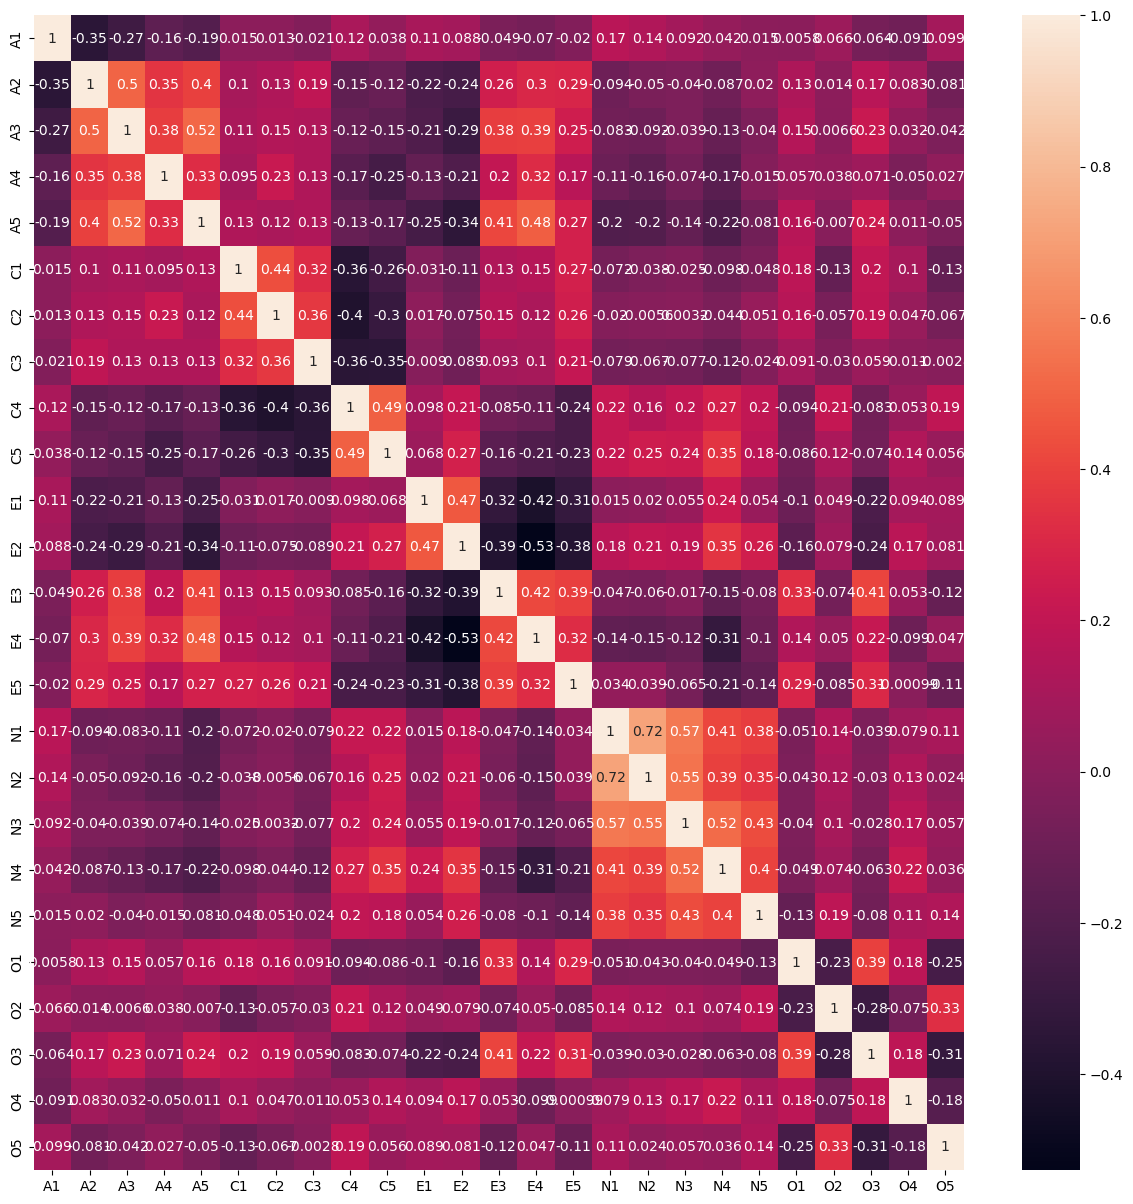

In [353]:
import seaborn as sns
import matplotlib.pyplot as plt
df_  =df.iloc[:,:-1]
fig = plt.figure(figsize=(15,15))
sns.heatmap(df_.corr(), annot=True,fmt='.2g');

In [370]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Bartlett의 구형성 검정
chi_square_value, p_value = calculate_bartlett_sphericity(df_)
print(f"Bartlett's sphericity test: chi-square = {chi_square_value:.2f}, p-value = {p_value:.5f}")

# KMO(Kaiser-Meyer-Olkin) 검정
kmo_value = calculate_kmo(df_)
print(f"KMO value: {kmo_value[1]}")


Bartlett's sphericity test: chi-square = 18146.07, p-value = 0.00000
KMO value: 0.8486452309468389


```
Bartlett의 구형성 검정과 KMO 검정을 통해 요인분석이 적절한지 확인
일반적으로 Bartlett 검정의 p-value가 0.05 미만이고, KMO 값이 0.6 이상이면 요인분석이 적절
```
> 요인분석을 진행한다

In [381]:
# 요인분석 객체 생성
fa = FactorAnalyzer(rotation=None)
fa.fit(df_)
ev, v = fa.get_eigenvalues() # 고유값(Eigenvalues) 확인
# print("Eigenvalues:")
# print(ev)

num_factors = (ev > 1).sum() # 적정 요인수 확인 (고유값 > 1 기준)
print(f"\n- 적정요인수 확인: {num_factors}")

fa.set_params(n_factors=num_factors, rotation='varimax') # 탐색적 요인분석 실시
fa.fit(df_)

# 요인 적재량(Factor Loadings) 출력
loadings = pd.DataFrame(fa.loadings_,index=df_.columns,columns=[f'factor{i}' for i in range(1,7)])
print("\n- 탐색적 요인분석에 따른 요인 적재량(Factor Loadings) :")
print(loadings.shape)
display(loadings)


- 적정요인수 확인: 6

- 탐색적 요인분석에 따른 요인 적재량(Factor Loadings) :
(25, 6)


,factor1,factor2,factor3,factor4,factor5,factor6
A1,0.095220,0.040783,0.048734,-0.530987,-0.113057,0.161216
A2,0.033131,0.235538,0.133714,0.661141,0.063734,-0.006244
A3,-0.009621,0.343008,0.121353,0.605933,0.033990,0.160106
A4,-0.081518,0.219717,0.235140,0.404594,-0.125338,0.086356
A5,-0.149616,0.414458,0.106382,0.469698,0.030977,0.236519
C1,-0.004358,0.077248,0.554582,0.007511,0.190124,0.095035
C2,0.068330,0.038370,0.674545,0.057055,0.087593,0.152775
C3,-0.039994,0.031867,0.551164,0.101282,-0.011338,0.008996
C4,0.216283,-0.066241,-0.638475,-0.102617,-0.143846,0.318359
C5,0.284187,-0.180812,-0.544838,-0.059955,0.025837,0.132423


```
factor_analyzer 라이브러리를 사용하여 요인분석을 수행합니다. 먼저 고유값(Eigenvalues)을 계산하고, 고유값이 1 이상인 요인의 개수를 적정 요인수로 결정. 그런 다음 varimax 회전을 적용하여 탐색적 요인분석을 실시하고, 요인 적재량(Factor Loadings)을 출력.


이 과정을 통해 데이터에 내재된 잠재적인 요인 구조를 파악 가능. 요인 적재량은 각 변수가 요인에 얼마나 기여하는지를 나타내므로, 이를 해석하여 요인의 의미를 파악 가능.
```

### 통계4
두명의 운동선수가 2번의 경기동안 득점한 결과이다.      
(1) 두 선수의 실력이 동일 하다 말할 수 있는지 검정하라   
(2) 오즈비를 구하여라    

<table>
<tr>
    <th></th>
    <td>1경기</td>
    <td>2경기</td> 
</tr>

<tr>
    <td>선수1</td> 
    <td>10</td> 
    <td>2</td>
</tr>

<tr>
    <td>선수2</td> 
    <td>3</td> 
    <td>6</td>   
</tr>

</table>  

In [343]:
from scipy.stats import chi2_contingency
cont = pd.DataFrame({'1경기':[10,3],	'2경기':[2,6]},index=['선수1','선수2'])
chi2_contingency(cont)

Chi2ContingencyResult(statistic=3.5378605769230766, pvalue=0.05998278296115886, dof=1, expected_freq=array([[7.42857143, 4.57142857],
       [5.57142857, 3.42857143]]))

- p_value가 0.05 이상이므로 두선수의 실력에 차이가 없다는 귀무가설을 기각할 수 없다

In [337]:
# 데이터
player1_scores = [10, 2]
player2_scores = [3, 6]

# 승리 횟수 계산
player1_wins = sum(player1 > player2 for player1, player2 in zip(player1_scores, player2_scores))
player2_wins = sum(player2 > player1 for player1, player2 in zip(player1_scores, player2_scores))

# 패배 횟수 계산
player1_losses = len(player1_scores) - player1_wins
player2_losses = len(player2_scores) - player2_wins

# 오즈비 계산
odds_ratio = (player1_wins / player1_losses) / (player2_wins / player2_losses)

print(f"선수 1의 승리 횟수: {player1_wins}")
print(f"선수 2의 승리 횟수: {player2_wins}")
print(f"오즈비: {odds_ratio:.2f}")

선수 1의 승리 횟수: 1
선수 2의 승리 횟수: 1
오즈비: 1.00


In [340]:
(player1_wins / player1_losses) 

1.0